### Functions

In [1]:
import subprocess
import sys
import pkg_resources


def check_and_install_packages(packages):
    """
    Check if the given packages are installed. If not, install them.

    Args:
        packages (list): A list of package names to check and install.
    """
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}

    for package in packages:
        if package not in installed_packages:
            print(f"'{package}' is not installed. Installing now...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"'{package}' has been installed successfully.")
        else:
            print(f"'{package}' is already installed.")


required_packages = ['numpy', 'matplotlib', 'pandas', 'seaborn']

check_and_install_packages(required_packages)



'numpy' is already installed.
'matplotlib' is already installed.
'pandas' is already installed.
'seaborn' is already installed.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import os
import random

In [3]:
def drawPeriodEdges(
    period, 
    N_periods, 
    y, 
    ax=None, 
    **kwargs
    ):

    """     
    Parameters:
    Draws edges based on the period.
    period (float): Period length.
    N_periods (int): Number of periods.
    y (float): Maximum height.
    ax (matplotlib.axes.Axes, optional): Axis to plot on. Defaults to None.
    **kwargs: Additional keyword arguments for the plot function.
    Arguments:
    None: This function plots edges for specific periodicities on the given axis.
    """
    
    if ax is None:
        ax = plt.gca()
    color = kwargs.pop('color', 'black')
    for i in range(N_periods+1):
        ax.plot([i*period, i*period], [0, y], '--', color=color, **kwargs)


def drawVectors(x1, x2, y1, y2=None, ax=None, **kwargs): 
    """
    Draws vectors on a plot using matplotlib's arrow function.

    Parameters:
    x1 (array-like): Starting x-coordinates of the vectors.
    x2 (array-like): Ending x-coordinates of the vectors.
    y1 (array-like): Starting y-coordinates of the vectors.
    y2 (array-like, optional): Ending y-coordinates of the vectors. If None, y1 is used as y2. Default is None.
    ax (matplotlib.axes.Axes, optional): The axes on which to draw the vectors. If None, the current axes (plt.gca()) is used. Default is None.
    **kwargs: Additional keyword arguments passed to matplotlib's arrow function.

    Arguments:
    length_includes_head (bool): If True, the length of the arrow includes the head. Default is True.
    color (str): Color of the arrow. Default is 'black'.
    facecolor (str): Face color of the arrow head. Default is the same as 'color'.
    edgecolor (str): Edge color of the arrow head. Default is the same as 'color'.
    head_width (float): Width of the arrow head. Default is 1.
    head_length (float): Length of the arrow head. Default is 1.

    Returns:
    None
    """
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    y1 = np.array(y1)
    y2 = np.array(y2) if y2 is not None else y1
    if ax is None:
        ax = plt.gca()
    length_includes_head = kwargs.pop('length_includes_head', True)
    color = kwargs.pop('color', 'black')
    facecolor = kwargs.pop('facecolor', color)
    edgecolor = kwargs.pop('edgecolor', color)
    head_width = kwargs.pop('head_width', 5)
    head_length = kwargs.pop('head_length', 5)
    for u, v, y, z in zip(x1, x2, y1, y2):
        ax.arrow(u, y, v-u, z-y,
                 length_includes_head=length_includes_head,
                 head_width=head_width,
                 head_length=head_length,
                 facecolor=facecolor,
                 edgecolor=edgecolor,
                 **kwargs)

In [4]:
def _get_indices(
    period,
    payments,
    start_day,
    anchor_day,
):
    """Helper function that, given a period length (in days), a series of payments,
    a timeline start day, and an anchor day at which any one of the periods starts, 
    determines the period index of each payment and the day 
    index of each payment.

    Anchor day is the start of a period. It does not matter which. For example, with
    a period of 5 it could be day 3, but it could also be day -2, 8, or 13.
    The zeroth period (period index = 0) is the period in which the start day falls.

    Args:
        period: number of days in one period
        payments: array of payment days
        start_day: First allowed day
        anchor_day: start day of period
    Returns:
        period index array with periods that payments fall in 
            start day has period index 0
        day index array with days within period that payments are at
    """
    period_idx = (payments - anchor_day) // period - (start_day - anchor_day) // period
    day_idx = (payments - anchor_day) % period
    return period_idx, day_idx

In [5]:
def objectiveFunction(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
):
    """Calculates the objective of the timeliine

    It measures the standard deviation of daily amounts across periods.
    It is computed as the square root of the average of the unbiased variance over all days in a period.

    Args:
        period: length of one period in days
        payments: Array of payments (in days)
        amounts: Array of payed amounts
        status: Array of booleans for payments being turned on or off
        start_day: first allowed day in the timeline (incl)
        end_period: last allowed day in the timeline (excl)
        anchor_day: start day of a period
    Returns:
        value of the objective of the timeliine
    """
    payments = np.array(payments, dtype=int)
    amounts = np.array(amounts, dtype=float)
    status =  np.array(status, dtype=bool)

    numperiods = (end_day-1 - anchor_day) // period + 1 - (start_day - anchor_day) // period

    # We only take payment, amounts and statuses, where the payment fall between start and end days
    idx = np.where((payments >= start_day) & (payments < end_day))[0]
    payments = payments[idx]
    amounts = amounts[idx]
    status = status[idx]

    # Get the period and day indices of payments
    period_idx, day_idx = _get_indices(period, payments, start_day, anchor_day)

    # Construct a matrix (numperiods x period) aggregating payments for each day in each period
    # This matrix sums payments that fall on the same day within a period
    mtx = sparse.csc_array((amounts * status, (period_idx, day_idx)), dtype=float, shape=(numperiods, period)).todense()

    
    objtv = np.sqrt(
    1 / (period * (numperiods - 1)) 
    * (
        (mtx**2).sum() # This is the first term in the objective function
        - 1 / numperiods * (mtx.sum(axis=0)**2).sum() # This is the second term
    )
)

    return objtv

In [6]:
def Power(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
):
    """Calculates the power of the timeliine

    It is the average over days in a period of the unbiased variance over periods
    of daily amounts

    Args:
        period: length of one period in days
        payments: Array of payments (in days)
        amounts: Array of payed amounts
        status: Array of booleans for payments being turned on or off
        start_day: first allowed day in the timeline 
        end_period: last allowed day in the timeline
        anchor_day: start day of a period
    Returns:
        value of the power of the timeliine 
    """

    payments = np.array(payments, dtype=int)
    amounts = np.array(amounts, dtype=float)
    status =  np.array(status, dtype=bool)

    numperiods = (end_day-1 - anchor_day) // period + 1 - (start_day - anchor_day) // period

    # We only take payment, amounts and statuses, where the payment fall between start and end days
    idx = np.where((payments >= start_day) & (payments < end_day))[0]
    payments = payments[idx]
    amounts = amounts[idx]
    status = status[idx]

    # Get the period and day indices of payments
    period_idx, day_idx = _get_indices(period, payments, start_day, anchor_day)

    # Create a matrix with payments in the same period and on the same day added up
    # The scipy sparse arrays do this automatically, so we use this functionality,
    # but then put it in a regular (a.k.a. dense) matrix
    mtx = sparse.csc_array((amounts * status, (period_idx, day_idx)), dtype=float, shape=(numperiods, period)).todense()

    
    pwr = np.sqrt(
        1 / (period * (numperiods - 1)) 
        * (
            (mtx**2).sum() 
        )
    )
    return pwr

In [7]:
def objectiveRemove(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
):
    """
    Calculate the objective function values for each payment with one payment removed at a time.

    This function iterates over each payment, temporarily sets its status to False, 
    and calculates the objective function value with the modified status. 
    The results are stored in an output array.

    Args:
        period (int): The period over which the objective function is calculated.
        payments (np.ndarray): An array of payment values.
        amounts (np.ndarray): An array of amount values.
        status (np.ndarray): A boolean array indicating the status of each payment.
        start_day (int): The start day for the calculation.
        end_day (int): The end day for the calculation.
        anchor_day (int): The anchor day for the calculation.

    Returns:
        np.ndarray: An array of objective function values with one payment removed at a time.
    """

    out = np.zeros_like(payments, dtype=float)
    for k in range(payments.shape[0]):
        s = np.copy(status)
        s[k] = False
        objective = objectiveFunction(
            period,
            payments,
            amounts,
            s,
            start_day,
            end_day,
            anchor_day,
        )
        out[k] = objective
    return out

def objectiveMove(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
    new_days,
):
    """
    Calculate the objective values for moving payment days within a specified range.
    Parameters:
    period (int): The period over which the objective function is evaluated.
    payments (np.ndarray): Array of current payment days.
    amounts (np.ndarray): Array of payment amounts.
    status (np.ndarray): Array indicating the status of each payment (True if active, False otherwise).
    start_day (int): The start day of the evaluation period.
    end_day (int): The end day of the evaluation period.
    anchor_day (int): The anchor day used in the objective function.
    new_days (np.ndarray): Array of new potential payment days to evaluate.
    Returns:
    np.ndarray: Array of objective values for each potential new payment day.
    """
 
    out = np.zeros_like(new_days, dtype=float)
    for k in range(new_days.shape[0]):
        for l in range(new_days.shape[1]):
            if start_day <= new_days[k, l] < end_day:
                p = np.copy(payments)
                p[k] = new_days[k, l]
                s = np.copy(status)
                s[k] = True  
                # Calculate objective
                objective = objectiveFunction(
                    period,
                    p,
                    amounts,
                    s,
                    start_day,
                    end_day,
                    anchor_day,
                )
                out[k, l] = objective
            else:
                # If the new day is out of bounds, assign a very high cost
                out[k, l] = np.inf
    return out


def objectiveSwap(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day
):
    """
    Calculate the objective matrix for swapping payment days within given bounds.
    This function evaluates the objective value for all possible swaps of payment days
    within the specified start and end days. If a swap results in a payment day falling
    outside the bounds, a high cost (infinity) is assigned to that swap.
    Parameters:
    period (int): The period over which the objective is calculated.
    payments (np.ndarray): Array of payment days.
    amounts (np.ndarray): Array of payment amounts.
    status (np.ndarray): Array indicating the active status of each payment.
    start_day (int): The earliest allowable payment day.
    end_day (int): The latest allowable payment day.
    anchor_day (int): A reference day used in the objective function calculation.
    Returns:
    np.ndarray: A matrix where each element [k, l] represents the objective value
                for swapping the k-th and l-th payment days.
    """
    out = np.zeros((payments.shape[0], payments.shape[0]), dtype=float)
    for k in range(payments.shape[0]):
        for l in range(payments.shape[0]):
            # Only swap if both payments stay within bounds
            if start_day <= payments[k] <= end_day and start_day <= payments[l] <= end_day: # check if <= or < for end_day
                p = np.copy(payments)
                p[k], p[l] = payments[l], payments[k]  # Swap payment days
                s = np.copy(status)
                s[k], s[l] = True, True  # Ensure both swapped payments are active
                # Calculate objective
                objective = objectiveFunction(
                    period,
                    p,
                    amounts,
                    s,
                    start_day,
                    end_day,
                    anchor_day
                )
                out[k, l] = objective
            else:
                # Assign a high cost if the swap results in out-of-bounds payments
                out[k, l] = np.inf
    return out


def objectiveSwapRemove(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
):
    """
    Computes the objective values for all possible swaps of payment statuses.
    This function iterates over all possible pairs of payments, swaps their 
    statuses, and computes the objective value for each swap using the 
    `objectiveFunction`.
    Parameters:
    period (int): The period for which the objective is calculated.
    payments (np.ndarray): An array of payment values.
    amounts (np.ndarray): An array of amounts corresponding to the payments.
    status (np.ndarray): A boolean array indicating the status of each payment.
    start_day (int): The start day of the period.
    end_day (int): The end day of the period.
    anchor_day (int): The anchor day for the period.
    Returns:
    np.ndarray: A 2D array where each element [k, l] represents the objective 
                value when the statuses of payments k and l are swapped.
    """
    out = np.zeros((payments.shape[0], payments.shape[0]), dtype=float)
    for k in range(payments.shape[0]):
        for l in range(payments.shape[0]):
            p = np.copy(payments)
            p[k] = payments[l]
            p[l] = payments[k]
            s = np.copy(status)
            s[k] = True
            s[l] = False
            objective = objectiveFunction(
                period,
                p,
                amounts,
                s,
                start_day,
                end_day,
                anchor_day,
            )
            out[k, l] = objective
    return out

In [8]:
def bestAction(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
    new_days,
    remove=False,
    move=True,
    swap=True,
    swapremove=False,
):
    """
    Determine the best action to optimize the objective function.
    Parameters:
    period (int): The current period.
    payments (np.ndarray): Array of payment dates.
    amounts (np.ndarray): Array of payment amounts.
    status (np.ndarray): Array of payment statuses.
    start_day (int): The start day of the period.
    end_day (int): The end day of the period.
    anchor_day (int): The anchor day for calculations.
    new_days (np.ndarray): Array of new potential payment days.
    remove (bool, optional): Whether to consider removing payments. Default is False.
    move (bool, optional): Whether to consider moving payments. Default is True.
    swap (bool, optional): Whether to consider swapping payments. Default is True.
    swapremove (bool, optional): Whether to consider swap-removing payments. Default is False.
    Returns:
    tuple: A tuple containing:
        - action (str): The best action to take ("move", "swap", "remove", "swapremove", or None).
        - action_pmt (int): The index of the payment to act upon.
        - action_tgt (int or None): The target index for the action (if applicable).
        - action_obj (float): The objective value after the action.
    """

    objective = objectiveFunction(
        period,
        payments,
        amounts,
        status,
        start_day,
        end_day,
        anchor_day,
    )

    mask = None
    action = None
    action_pmt = None
    action_tgt = None
    action_obj = objective

    if move:
        obj = objectiveMove(
            period,
            payments,
            amounts,
            status,
            start_day,
            end_day,
            anchor_day,
            new_days,
        )
        idx = np.unravel_index(obj.argmin(), obj.shape)
        potential_tgt = new_days[idx[0], idx[1]]

        if obj[idx] < action_obj and potential_tgt in new_days[idx[0]]:
            action = "move"
            action_pmt = idx[0]
            action_tgt = potential_tgt
            action_obj = obj[idx]


    
    if swap:
        obj = objectiveSwap(
            period,
            payments,
            amounts,
            status,
            start_day,
            end_day,
            anchor_day,
        )

        for i in range(payments.shape[0]):
            for j in range(i + 1, payments.shape[0]):
                if i == j:
                    continue
                if (payments[j] not in new_days[i]) or (payments[i] not in new_days[j]):
                    obj[i, j] = np.inf
                    obj[j, i] = np.inf

        idx = np.unravel_index(obj.argmin(), obj.shape)
        
        if obj[idx] < action_obj and idx[0] != idx[1]:
            action = "swap"
            action_pmt = idx[0]
            action_tgt = idx[1]
            action_obj = obj[idx]



    if remove: 
        obj = objectiveRemove(
            period,
            payments,
            amounts,
            status,
            start_day,
            end_day,
            anchor_day,
        )
        idx = np.argmin(obj)
        if obj[idx] < action_obj:
            action = "remove"
            action_pmt = idx
            action_obj = obj[idx]

    if swapremove:
        obj = objectiveSwapRemove(
            period,
            payments,
            amounts,
            status,
            start_day,
            end_day,
            anchor_day,
        )

        mask = mask if mask is not None else np.any(new_days[:, :, np.newaxis] == payments[np.newaxis, np.newaxis, :], axis=1) # Check if the payments are within the allowed days
        obj[~mask] = np.inf
        
        idx = np.unravel_index(obj.argmin(), obj.shape)
        if obj[idx] < action_obj:
            action = "swapremove"
            action_pmt = idx[0]
            action_tgt = idx[1]
            action_obj = obj[idx]
        

    return action, action_pmt, action_tgt, action_obj


In [9]:
def applyAction(
    action, 
    action_pmt, 
    action_tgt, 
    payments,
    status,
    original_new_days,
):
    """
    Applies the specified action to the payment schedule.
    Parameters:
    action (str): The action to perform. Can be "remove", "move", "swap", or "swapremove".
    action_pmt (int): The payment identifier on which the action is performed.
    action_tgt (int): The target payment identifier or day, depending on the action.
    payments (dict): A dictionary mapping payment identifiers to their scheduled days.
    status (dict): A dictionary mapping payment identifiers to their active status (True/False).
    original_new_days (dict): A dictionary mapping payment identifiers to a list of valid days they can be moved to.
    Raises:
    ValueError: If an invalid move, swap, or swapremove action is attempted.
    """  
    if action == "remove":
        status[action_pmt] = False
    elif action == "move":
        if action_tgt in original_new_days[action_pmt]:
            payments[action_pmt] = action_tgt
            status[action_pmt] = True
        else:
            raise ValueError(f"Attempted to move payment {action_pmt} to an invalid day {action_tgt}")
    
    elif action == "swap":
        if action_pmt == action_tgt:
            raise ValueError(f"Attempted to swap the same payment {action_pmt} with itself")
        if payments[action_tgt] in original_new_days[action_pmt] and payments[action_pmt] in original_new_days[action_tgt]:
            payments[action_pmt], payments[action_tgt] = payments[action_tgt], payments[action_pmt]
            status[action_pmt] = status[action_tgt] = True
        else:
            raise ValueError(f"Attempted to swap payments {action_pmt} and {action_tgt} to invalid positions")
            
    elif action == "swapremove":
        if payments[action_tgt] in original_new_days[action_pmt]:
            payments[action_pmt], payments[action_tgt] = payments[action_tgt], payments[action_pmt]
            status[action_pmt] = True
            status[action_tgt] = False
        else:
            raise ValueError(f"Attempted to swapremove payment {action_pmt} to an invalid position")



In [10]:
def performOptimization(
    period,
    payments,
    amounts,
    status,
    start_day,
    end_day,
    anchor_day,
    original_new_days,
    move=True,
    swap=True,
    remove=True,
    swapremove=True,
    verbose=False
):
    """
    Perform optimization on a set of payments within a specified period.
    This function iteratively applies the best action (move, swap, remove, or swapremove)
    to optimize the payments within the given window defined by start_day and end_day.
    The optimization process continues until no further actions can be found.
    Parameters:
    - period (int): The period over which the optimization is performed.
    - payments (list): A list of payment amounts.
    - amounts (list): A list of amounts corresponding to the payments.
    - status (list): A list indicating the status of each payment.
    - start_day (int): The starting day of the optimization window.
    - end_day (int): The ending day of the optimization window.
    - anchor_day (int): The anchor day used in the optimization process.
    - original_new_days (list): A list of original and new days for the payments.
    - move (bool, optional): Whether to consider move actions. Default is True.
    - swap (bool, optional): Whether to consider swap actions. Default is True.
    - remove (bool, optional): Whether to consider remove actions. Default is True.
    - swapremove (bool, optional): Whether to consider swapremove actions. Default is True.
    - verbose (bool, optional): If True, prints detailed information about each step. Default is False.
    Returns:
    - tuple: A tuple containing:
        - payments (list): The optimized list of payments.
        - amounts (list): The list of amounts corresponding to the optimized payments.
        - status (list): The updated status of each payment.
        - objective_values (list): A list of objective values after each action.
        - original_payments (list): A copy of the original payments before optimization.
    """
    counter = 0
    objective_values = []  
    original_payments = payments.copy()

    while True:
        # Find the best action within the window
        action, action_pmt, action_tgt, action_obj = bestAction(
            period,
            payments,
            amounts,
            status,
            start_day,
            end_day,
            anchor_day,
            original_new_days,
            remove=remove,
            move=move,
            swap=swap,
            swapremove=swapremove,
        )
        
        # If no action can be found, break out of the loop
        if action is None:
            break

        # Apply the action within the current window
        applyAction(action, action_pmt, action_tgt, payments, status, original_new_days)


        # Calculate the objective for the entire timeline from start_day to end_day
        global_objective = objectiveFunction(
            period=period,
            payments=payments,
            amounts=amounts,
            status=status,
            start_day=start_day,
            end_day=end_day,
            anchor_day=anchor_day,
        )

        # Store the global objective value after each action
        objective_values.append(global_objective)

        counter += 1
        if verbose:
            print(f"Step {counter}")
            print("-" * 80)
            print(f"Best action: {action}")
            print(f"Payment index: {action_pmt}")
            print(f"Target: {action_tgt}")
            print(f"Global Objective value after action: {global_objective}")
            print("-" * 80)
            print("Updated payments:", payments)
            print("Updated status: ", status)
            print("=" * 80)

    return payments, amounts, status, objective_values, original_payments


In [11]:
def optimizePayments(
    period,
    patterns,
    start_day,
    end_day,
    anchor_day,
    initial_status=None,
    original_new_days=None,
    move=True,
    swap=True,
    remove=True,
    swapremove=True,
    window_size=None,  # Optional
    step_size=None,  # Optional
    verbose=False
):
    """
    Optimize payment schedules based on given patterns and constraints.
    Parameters:
    period (int): The period over which the optimization is performed.
    patterns (list of dict): List of payment patterns, each containing 'days', 'amounts', and 'ids'.
    start_day (int): The starting day for the optimization.
    end_day (int): The ending day for the optimization.
    anchor_day (int): The anchor day for the optimization.
    initial_status (np.ndarray, optional): Initial status of the payments. Defaults to None.
    original_new_days (np.ndarray, optional): Array of original new days for each payment. Defaults to None.
    move (bool, optional): Whether to allow moving payments. Defaults to True.
    swap (bool, optional): Whether to allow swapping payments. Defaults to True.
    remove (bool, optional): Whether to allow removing payments. Defaults to True.
    swapremove (bool, optional): Whether to allow swap-remove operations. Defaults to True.
    window_size (int, optional): Size of the window for windowed optimization. Defaults to None.
    step_size (int, optional): Step size for windowed optimization. Defaults to None.
    verbose (bool, optional): Whether to print verbose output. Defaults to False.
    Returns:
    tuple: A tuple containing:
        - payments (np.ndarray): Optimized payment days.
        - amounts (np.ndarray): Optimized payment amounts.
        - status (np.ndarray): Status of the payments.
        - ids (np.ndarray): IDs of the payments.
        - all_objectives (list): List of objective values for each window (if windowed optimization is used).
        - last_objectives_per_window (list): List of global objective values after each window (if windowed optimization is used).
        - power (list): List of power values after each window (if windowed optimization is used).
        - payments_of_windows (list): List of payments for each window (if windowed optimization is used).
    """
    payments = np.concatenate([pattern['days'] for pattern in patterns])
    amounts = np.concatenate([pattern['amounts'] for pattern in patterns])
    ids = np.concatenate([pattern['ids'] for pattern in patterns])
    original_new_days = np.array([np.arange(p - 2, p + 3) for p in payments])

    if initial_status is not None:
        status = initial_status
    else:
        status = np.ones_like(payments, dtype=bool)

    if verbose:
        print("*" * 80)
        print("Running optimization with only move and swap...")
        print("*" * 80)

    # Initial optimization with move and swap only
    payments, amounts, status, objective_values, original_payments = performOptimization(
        period,
        payments,
        amounts,
        status,
        start_day=start_day,
        end_day=end_day,
        anchor_day=anchor_day,
        original_new_days=original_new_days,
        move=True,
        swap=True,
        remove=False,
        swapremove=False,
        verbose=verbose
    )

    first_stage_payments = payments.copy()
    first_stage_amounts = amounts.copy()
    first_stage_status = status.copy()

    if window_size is not None and step_size is not None:
        # Windowed optimization (first move/swap, then full)

        current_start_day = start_day
        current_end_day = start_day + window_size

        all_objectives = []
        last_objectives_per_window = []
        power = []
        payments_of_windows = []
        
        while current_end_day < end_day + step_size:
            if verbose:
                print("*" * 80)
                print(f"Running windowed optimization for window: {current_start_day} to {current_end_day}")
                print("*" * 80)

            within_window = (payments >= current_start_day) & (payments <= current_end_day)

            payments_window = payments[within_window]
            amounts_window = amounts[within_window]
            status_window = status[within_window]
            ids_window = ids[within_window]

            payments_window, amounts_window, status_window, obj, original_payments = performOptimization(
                period=period,
                payments=payments_window,
                amounts=amounts_window,
                status=status_window,
                start_day=current_start_day,
                end_day=current_end_day,
                anchor_day=anchor_day,
                original_new_days=original_new_days[within_window],
                move=True,
                swap=True,
                remove=True,
                swapremove=True,
                verbose=verbose
            )
            
            indices_within_window = np.where(within_window)[0]
            payments[indices_within_window] = payments_window
            amounts[indices_within_window] = amounts_window
            status[indices_within_window] = status_window

            # Calculate the global objective after each windowed optimization
            global_objective = objectiveFunction(
                period=period,
                payments=payments,
                amounts=amounts,
                status=status,
                start_day=start_day,
                end_day=current_end_day,
                anchor_day=anchor_day
            )


            # Calculate the power after each windowed optimization
            pwr = Power(
                period=period,
                payments=payments,
                amounts=amounts,
                status=status,
                start_day=start_day,
                end_day=current_end_day,
                anchor_day=anchor_day
            )

            all_objectives.append(obj)
            last_objectives_per_window.append(global_objective)
            power.append(pwr)
            payments_of_windows.append(payments_window)

            if verbose:
                print(f"Global objective after window {current_start_day} to {current_end_day}: {global_objective}")
                print(f"Updated payments: {payments_window}")
                print(f"Updated status: {status_window}")
                print("_____________________________________________________________________________________________")
            
            current_end_day += step_size

        
        return payments, amounts, status, ids, all_objectives, last_objectives_per_window, power, payments_of_windows

    # Full optimization with all options (move, swap, remove, swapremove)
    if verbose:
        print("*" * 80)
        print("Running full optimization with move, swap, remove, and swapremove")
        print("*" * 80)

    payments = first_stage_payments.copy()
    amounts = first_stage_amounts.copy()
    status = first_stage_status.copy()

    payments, amounts, status, objective_values, original_payments = performOptimization(
        period,
        payments,
        amounts,
        status,
        start_day=start_day,
        end_day=end_day,
        anchor_day=anchor_day,
        original_new_days=original_new_days,
        move=True,
        swap=True,
        remove=True,
        swapremove=True,
        verbose=verbose
    )


    return payments, amounts, status, ids, objective_values, original_payments


In [12]:
def make_pattern(
    N_days,
    period, 
    start_day, 
    end_day, 
    amount, 
    dDay=0, 
    dAmount=0, 
    pi=1, 
    pattern_id=0,
):
    """
    Generates a pattern of days and corresponding amounts based on the given parameters.
    
    Parameters:
    N_days (int): Total number of days to consider.
    period (int): The period between each occurrence in the pattern.
    start_day (int): The starting day of the pattern.
    end_day (int): The ending day of the pattern.
    amount (float): The base amount for each occurrence.
    dDay (int, optional): The maximum deviation for the days. Defaults to 0.
    dAmount (float, optional): The maximum deviation for the amounts. Defaults to 0.
    pi (float or int, optional): Determines the selection of periods. If less than 1, 
                                 it is treated as a probability. If between 1 and 1.99, 
                                 all periods are selected. If 2 or more, it specifies 
                                 the number of periods to randomly select. Defaults to 1.
    pattern_id (int, optional): An identifier for the pattern. Defaults to 0.
    
    Returns:
    dict: A dictionary containing the following keys:
        - 'Pattern': The pattern identifier.
        - 'days': An array of days in the pattern.
        - 'amounts': An array of amounts corresponding to each day.
        - 'ids': An array of unique identifiers for each occurrence in the pattern.
    """
    N_periods = (N_days-1)//period + 1
    if pi < 1:
        i = np.where(np.random.uniform(size=N_periods) <= abs(pi))[0]
    elif pi < 1.99:
        i = np.arange(N_periods)
    else:
        i = np.sort(np.random.choice(np.arange(N_periods), replace=False, size=pi))
   
    x = i * period + start_day
    x = x[x <= end_day]
    
    # Limit movement to 50% of the days
    if dDay > 0:
        num_to_move = min(len(x), max(1, len(x) // 2))  # Limit movement to 50% of the days
        move_indices = np.random.choice(len(x), size=num_to_move, replace=False)  # Randomly select indices to move
        
        # Apply deviations only to the selected indices
        x[move_indices] += np.random.randint(low=-dDay, high=dDay, size=num_to_move)
        x = np.clip(x, start_day, end_day)  # Ensure days are within bounds

    y = np.full_like(x, amount, dtype=float)
    if dAmount > 0:
        y += np.random.uniform(low=-min(amount, dAmount), high=dAmount, size=len(y)).round(2)
    
    ids = np.arange(len(x)) + 10 ** (pattern_id + 1)

    return {'Pattern': pattern_id, 'days': x, 'amounts': y.round(2), 'ids': ids}


In [13]:
def make_white_noise(
    N_days, 
    min_amount, 
    max_amount, 
    pi, 
    label, 
    ids
    ):
    """
    Generate a white noise pattern for a given number of days with random payment amounts.
    Parameters:
    N_days (int): Number of days to generate the pattern for.
    min_amount (float): Minimum payment amount.
    max_amount (float): Maximum payment amount.
    pi (float or int): Probability threshold or number of days to select.
        If pi < 1, it is treated as a probability threshold.
        If pi >= 1, it is treated as the number of days to select.    
    label (str): Label for the pattern.
    ids (array-like): Array of IDs for the generated payments.
    Returns:
    dict: A dictionary containing the following keys:
        - 'Pattern' (str): The label for the pattern.
        - 'days' (array-like): The days on which payments occur.
        - 'amounts' (array-like): The payment amounts for the corresponding days.
        - 'ids' (array-like): The IDs for the generated payments.
    """
    if pi < 1:
        x = np.where(np.random.uniform(size=N_days) <= abs(pi))[0]
    else:
        x = np.random.choice(np.arange(N_days), replace=False, size=pi)
    
    # Generate random payment amounts for those days
    y = np.random.uniform(low=min(abs(min_amount), abs(max_amount)), high=max(abs(min_amount), abs(max_amount)), size=len(x))
    ids = np.arange(len(x)) + 10**8

    return {'Pattern': label, 'days': x, 'amounts': y.round(2), 'ids': ids}

In [14]:
def make_exponential_noise(
    N_days, 
    scale, 
    pi, 
    label, 
    ids
    ):
    """
    Generate a dictionary containing exponential noise data.
    Parameters:
    N_days (int): Number of days to generate data for.
    scale (float): Scale parameter for the exponential distribution.
    pi (float or int): Probability threshold or number of days to select.
                       If pi < 1, it is treated as a probability threshold.
                       If pi >= 1, it is treated as the number of days to select.
    label (str): Label for the pattern.
    ids (array-like): Array of IDs (not used in the function, but included in the return dictionary).
    Returns:
    dict: A dictionary with the following keys:
        - 'Pattern': The provided label.
        - 'days': Array of selected days.
        - 'amounts': Array of generated exponential noise amounts.
        - 'ids': Array of generated IDs starting from 10^8.
    """
    if pi < 1:
        x = np.where(np.random.uniform(size=N_days) <= abs(pi))[0]
    else:
        x = np.random.choice(np.arange(N_days), replace=False, size=pi)
    
    y = np.random.exponential(scale=scale, size=len(x))
    ids = np.arange(len(x)) + 10**8

    return {'Pattern': label, 'days': x, 'amounts': y.round(2), 'ids': ids}


In [15]:
def filter_by_percentile(
      data, 
      lower_percentile, 
      upper_percentile
    ):
    """
    Filters out payments below or above the given percentile thresholds.
    
    Args:
    - data: List of payment patterns (each as a dict with 'days', 'amounts', and 'ids').
    - lower_percentile: The lower percentile threshold for filtering.
    - upper_percentile: The upper percentile threshold for filtering.
    
    Returns:
    - filtered_data: The filtered payment patterns, with payments outside the percentile range removed.
    """
    all_amounts = np.concatenate([pattern['amounts'] for pattern in data])
    
    lower_threshold = np.percentile(all_amounts, lower_percentile)
    upper_threshold = np.percentile(all_amounts, upper_percentile)
    
    
    filtered_data = []
    for pattern in data:
        amounts = pattern['amounts']
        days = pattern['days']
        ids = pattern['ids']
        
        valid_indices = np.where((amounts >= lower_threshold) & (amounts <= upper_threshold))[0]
        
        filtered_data.append({
            'Pattern': pattern['Pattern'],
            'days': days[valid_indices],
            'amounts': amounts[valid_indices],
            'ids': ids[valid_indices]
        })
    print(f"Filtered out payments below {lower_percentile}th percentile and above {upper_percentile}th percentile")
    print(f"Length of data before filtering: {len(all_amounts)}")
    print(f"Length of data after filtering: {len(np.concatenate([pattern['amounts'] for pattern in filtered_data]))}")
    print(f"Original Range: {all_amounts.min()} - {all_amounts.max()}")
    print(f"New Range: {np.concatenate([pattern['amounts'] for pattern in filtered_data]).min()} - {np.concatenate([pattern['amounts'] for pattern in filtered_data]).max()}")
    
    return filtered_data

# One time thing

### Data Generation

In [16]:
np.random.seed(30)
data = []

start_day, anchor_day  = 0, 0
end_day    = 364
period     = [7, 14, 30]
num_days   = 364
dDay       = [0, 2, 2]
dAmount    = [100, 100]
amount     = [1000, 3000, 8000]
noise_pi   = 0.3
pattern_id = [0, 1, 2]

##############################################################################################################

pattern1 = make_pattern(N_days=num_days, period=period[0], 
                        start_day=start_day, end_day=end_day,
                        amount=amount[0], dDay=dDay[1], dAmount=100, pi=1, pattern_id=0)

pattern2 = make_pattern(N_days=num_days, period=period[1],
                        start_day=4, end_day=end_day,
                        amount=amount[1], dDay=dDay[1], dAmount=100, pi=1, pattern_id=1)

pattern3 = make_pattern(N_days=num_days, period=period[2],
                        start_day=20, end_day=end_day,
                        amount=amount[2], dDay=dDay[2], dAmount=100, pi=1, pattern_id=2)

# any ids with id > 10^8 are considered noise
noise = make_exponential_noise(N_days=num_days, scale=3000, pi=noise_pi, label='noise', ids=1)

data.append(pattern1)
#data.append(pattern2)
#data.append(pattern3)
data.append(noise)

In [17]:
days, amounts, ids = np.concatenate([d['days'] for d in data]), np.concatenate([d['amounts'] for d in data]), np.concatenate([d['ids'] for d in data])
status_og = np.ones_like(days, dtype=bool)
num_patterns = len(data) - 1 if 'noise' in [d['Pattern'] for d in data] else len(data)
noise_percentage = np.round((len(noise['days']) / len(days) * 100), 2)
print(f'{noise_percentage}% of the data is noise, {len(noise["days"])} payments out of {len(days)}')

avg_amounts = [np.mean(pattern['amounts']) for pattern in data if pattern['Pattern'] != 'noise']
print(f"Average amounts: {avg_amounts}")

filter_data = filter_by_percentile(data, 5, 100)

filter_data_days = np.concatenate([d['days'] for d in filter_data])
filter_data_amounts = np.concatenate([d['amounts'] for d in filter_data])
filter_data_ids = np.concatenate([d['ids'] for d in filter_data])

removed_days = np.setdiff1d(days, filter_data_days)
removed_amounts = amounts[np.isin(days, removed_days)]
removed_ids = ids[np.isin(days, removed_days)]

print(f"Removed {len(removed_days)} payments out of {len(days)}, with ids: {removed_ids}")


70.62% of the data is noise, 125 payments out of 177
Average amounts: [996.2780769230769]
Filtered out payments below 5th percentile and above 100th percentile
Length of data before filtering: 177
Length of data after filtering: 168
Original Range: 94.48 - 15572.36
New Range: 334.89 - 15572.36
Removed 9 payments out of 177, with ids: [100000000 100000006 100000012 100000036 100000067 100000082 100000095
 100000104 100000121]


### Windowed Optimisation

In [18]:
# Default Values
window_size = 4 * period[0]
step_size = 2 * period[0]

# Runs the windowed optimisation
optimized_payments, optimized_amounts, optimized_status, optimized_ids, all_objectives, last_objectives_per_window, power, window_pmts = optimizePayments(
    period=period[0],
    patterns=filter_data,
    start_day=start_day,
    end_day=end_day,
    anchor_day=anchor_day,
    window_size=window_size,
    step_size=step_size,
    verbose=True
)

********************************************************************************
Running optimization with only move and swap...
********************************************************************************
Step 1
--------------------------------------------------------------------------------
Best action: move
Payment index: 140
Target: 294
Global Objective value after action: 2088.5216628261655
--------------------------------------------------------------------------------
Updated payments: [  0   7  14  21  28  33  42  49  54  64  70  77  84  91  96 105 112 119
 126 131 139 148 155 161 168 173 183 189 195 203 210 216 223 229 237 245
 250 259 266 273 279 287 295 302 309 315 322 329 336 343 351 357   6  12
  13  16  19  27  29  35  40  41  45  47  52  58  59  62  65  69  73  79
  83  84  91  95  96 100 103 104 107 110 112 116 119 124 127 129 130 131
 133 134 136 139 140 147 149 151 156 162 165 166 167 169 170 171 177 179
 190 192 195 196 197 201 203 209 213 217 220 225 229 230 233

### Post Processing

In [19]:
optimized_mask = (optimized_payments >= start_day) & (optimized_payments <= end_day)

optimized_final_days = optimized_payments[optimized_mask]
optimized_final_amounts = optimized_amounts[optimized_mask]
optimized_final_status = optimized_status[optimized_mask]
optimized_final_ids = optimized_ids[optimized_mask]
optimized_final_status[(optimized_final_days < start_day) | (optimized_final_days >= end_day)] = False


df = pd.DataFrame(data=
                  {'f_days': optimized_final_days, 
                  'init_days': filter_data_days,
                  'i_days_ip': filter_data_days % period[0],
                  'f_days_ip': optimized_final_days % period[0],
                  'amounts': optimized_final_amounts, 
                  'status': optimized_final_status, 
                  'ids': optimized_final_ids})



df_power = pd.DataFrame(data=
                  {'Power': np.round(power, 2), 
                  'Objective': np.round(last_objectives_per_window, 2),
                  'Res_Power (%)':  np.round((np.array(power) - np.array(last_objectives_per_window)) / np.array(power) * 100, 2)}) # how much of the power is in the resonant frequencies


# Flagging
res_power = np.round((np.array(power) - np.array(last_objectives_per_window)) / np.array(power) * 100, 2)
flagged_windows = []

last_window_res_power = res_power[-1]

for i in range(len(res_power) - 2):
    # Check all conditions:
    
    # 1. res_power of window[i+1] is lower than window[i]
    # 2. res_power of window[i+2] is at least 5% lower than window[i]
    # 3. res_power of window[i+2] is less than 90
    # 4. The last window's res_power is worse than the flagged one
    if (res_power[i + 1] < res_power[i]) and \
       (res_power[i + 2] <= res_power[i] - 5) and \
       (res_power[i + 2] < 90) and \
       (last_window_res_power < res_power[i]):
        flagged_windows.append(i-1)
        print(f"Flagged: Window {i-1} satisfies all conditions, including comparison to the last window.")

dictio = {}

if flagged_windows:
    all_flagged_payments = np.concatenate([window_pmts[window] for window in flagged_windows])

    for pmt in all_flagged_payments:
        indices = np.where(optimized_payments == pmt)[0]
        if len(indices) > 0:  # Only proceed if there's at least one match
            idx = indices[0]  # Take the first matching index
            dictio[pmt] = {'amount': optimized_amounts[idx], 'id': optimized_ids[idx]}
        else:
            print(f"Warning: No match found for payment {pmt} in optimized_payments.")

    flagged_payments = np.unique(all_flagged_payments)
    optimized_mask = optimized_final_status & ~np.isin(optimized_final_days, flagged_payments)

    non_flagged_payments_days = optimized_final_days[optimized_mask]
    non_flagged_payments_amounts = optimized_final_amounts[optimized_mask]
    non_flagged_payments_ids = optimized_final_ids[optimized_mask]
else:
    print("No windows satisfy the specified conditions. No payments are flagged.")

No windows satisfy the specified conditions. No payments are flagged.


### Visualisation

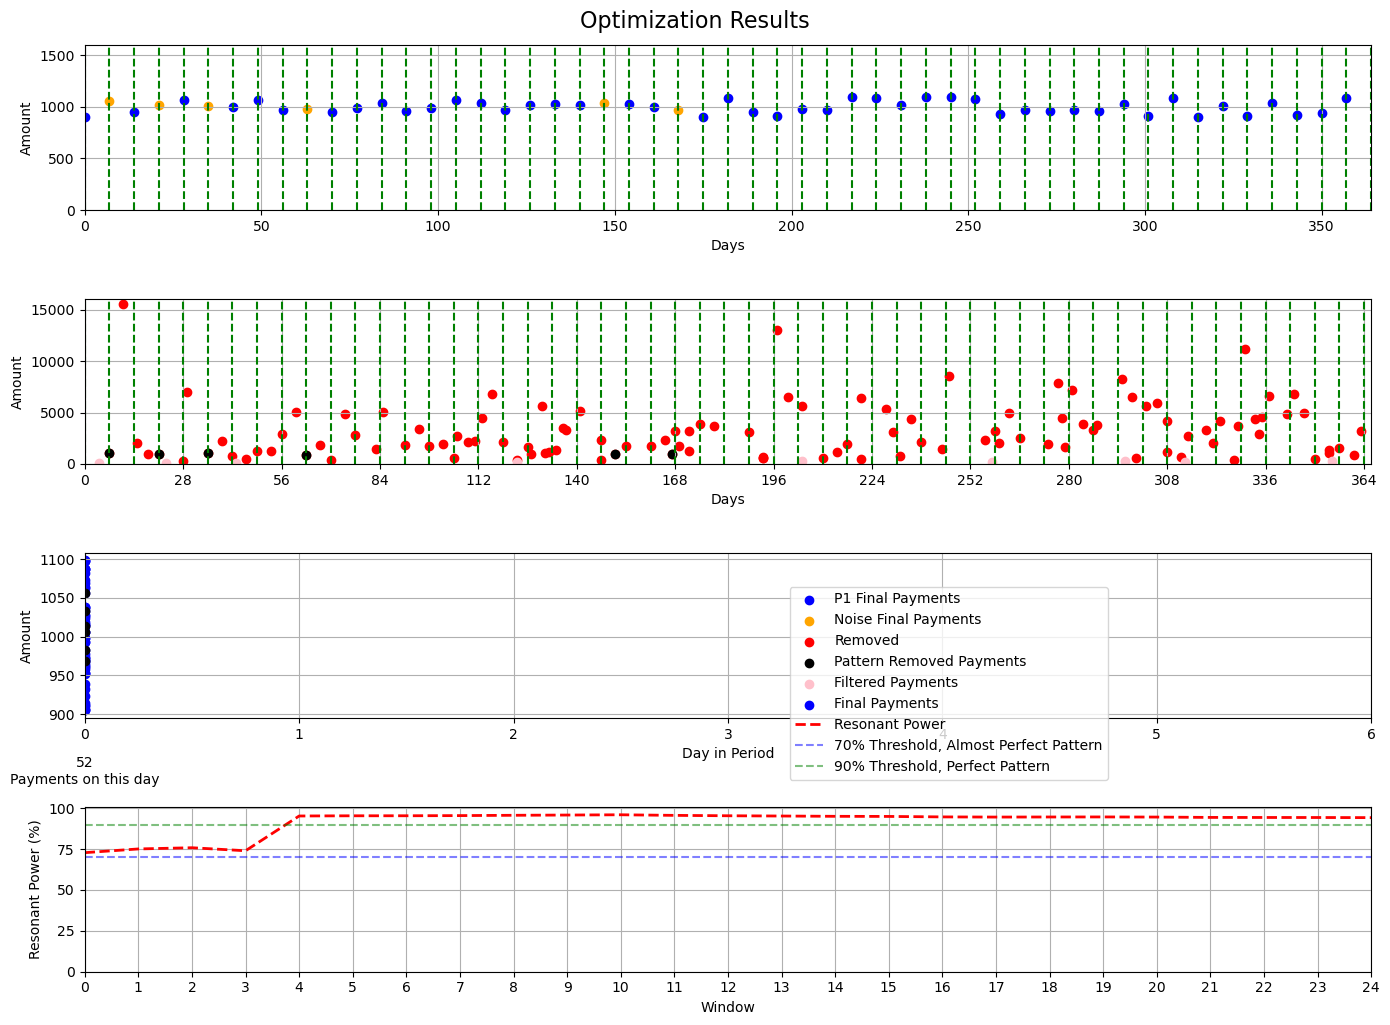

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1

colors = ['blue', 'green', 'orange']

for i in range(len(filter_data)-1):
    ax1.scatter(optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**(i+1)) & (optimized_final_ids < 10**(i+2))], 
                optimized_final_amounts[optimized_final_status & (optimized_final_ids >= 10**(i+1)) & (optimized_final_ids < 10**(i+2))],
                color=colors[i], label=f'P{i+1} Final Payments') 
    
if optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**8)].size > 0:    
    ax1.scatter(optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**8)],
                optimized_final_amounts[optimized_final_status & (optimized_final_ids >= 10**8)], 
                c='orange', label='Noise Final Payments')

if flagged_windows:
    ax1.axvspan(window_pmts[flagged_windows[0]-1][-1]+1, end_day, color='red', alpha=0.2, label='Flagged Payments')


ax1.set_xlabel('Days')
ax1.set_ylabel('Amount')
ax1.set_xlim(start_day, end_day)
drawPeriodEdges(period[0], end_day//period[0], max(optimized_final_amounts) + 500, ax=ax1, color='g')

ax1.set_ylim(0, max(optimized_final_amounts[optimized_final_status]) + 500)


# Plot 2

assert len(optimized_final_days) == len(optimized_final_amounts) == len(optimized_final_status), \
    "Mismatch."

ax2.scatter(optimized_final_days[~optimized_final_status], optimized_final_amounts[~optimized_final_status], c='r', label='Removed')

if optimized_final_days[~optimized_final_status & (optimized_final_ids < 10**8)].size > 0:
    ax2.scatter(optimized_final_days[~optimized_final_status & (optimized_final_ids < 10**8)],
                    optimized_final_amounts[~optimized_final_status & (optimized_final_ids < 10**8)], 
                    c='black', label='Pattern Removed Payments')
ax2.scatter(removed_days, removed_amounts, c='pink', label='Filtered Payments')

ax2.set_xlabel('Days')
ax2.set_ylabel('Amount')
ax2.set_xticks(np.arange(start_day, end_day+2, 28))
ax2.set_xlim(start_day, end_day+2)
ax2.set_ylim(0, max(optimized_final_amounts) + 500)
drawPeriodEdges(period[0], end_day//period[0], max(optimized_final_amounts) + 500, ax=ax2, color='g', alpha=1)

# Plot 3

noise_payments = optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**8)]
noise_amounts = optimized_final_amounts[optimized_final_status & (optimized_final_ids >= 10**8)]

optimized_on_payments = optimized_final_days[optimized_final_status]
optimized_on_amounts = optimized_final_amounts[optimized_final_status]

ax3.scatter(optimized_on_payments%period[0],
            optimized_on_amounts, 
            color='blue', label='Final Payments', marker='o', alpha=1)

if optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**8)].size > 0:
    
    ax3.scatter(optimized_final_days[optimized_final_status & (optimized_final_ids >= 10**8)] % period[0], 
            optimized_final_amounts[optimized_final_status & (optimized_final_ids >= 10**8)], 
            color='black', label='Noise Final Payments', marker='o', alpha=1)

ax3.set_xlim(0, period[0]-1)
ax3.set_xlabel('Day in Period')
ax3.set_ylabel('Amount')

days_in_period = optimized_final_days[optimized_final_status] % period[0]

unique_days, counts = np.unique(days_in_period, return_counts=True)

for day, count in zip(unique_days, counts):
    ax3.text(day, ax3.get_ylim()[0] - 0.3 * (ax3.get_ylim()[1] - ax3.get_ylim()[0]),
             str(count), color='black', ha='center')

sum_text = "Payments on this day"


ax3.text((unique_days[-1] + unique_days[0]) / 2, 
          1* ax3.get_ylim()[0] - 0.4 * (ax3.get_ylim()[1] - ax3.get_ylim()[0]),
          sum_text, color='black', ha='center')

# Plot 4

ax4.plot(res_power, linewidth = 2,linestyle='--', color = 'r', label='Resonant Power')
if flagged_windows:
      ax4.axvline(x=flagged_windows[0], color='c', linestyle='--', label='Flagged Window')
ax4.set_xlabel('Window')
ax4.set_ylabel('Resonant Power (%)')
ax4.set_ylim(ymin=0, ymax=101)
ax4.set_xlim(xmin=0, xmax=len(power)-1)
ax4.set_xticks(np.arange(0, len(power), 1))
ax4.axhline(y=70, color='b', linestyle='--', label='70% Threshold, Almost Perfect Pattern', alpha=.5)
ax4.axhline(y=90, color='g', linestyle='--', label='90% Threshold, Perfect Pattern', alpha=.5)

unique_handles, unique_labels = [], []

for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)

fig.legend(unique_handles, unique_labels, bbox_to_anchor=(.8, .45))
plt.tight_layout()
plt.suptitle('Optimization Results', fontsize=16, y=1.02)
#plt.savefig(f'P1234_halfPatterns{len(filter_data)-1}_Amount{amount[0]}_da{dAmount[0]}_Sd{start_day}_dd{dDay[0]}_p{period[0]}_p{period[1]}.png', bbox_inches='tight')
plt.show()


# Second Run (for multiple periodicities)

In [21]:
second_data = []
off_days = filter_data_days[~optimized_final_status]
off_amounts = filter_data_amounts[~optimized_final_status]
off_ids = filter_data_ids[~optimized_final_status]
second_data.append({'Pattern': 'off', 'days': off_days, 'amounts': off_amounts, 'ids': off_ids, 'status': np.ones_like(off_days, dtype=bool)})

In [ ]:
window_size = 4 * period[1]
step_size = 1 * period[1]


sec_optimized_payments, sec_optimized_amounts, sec_optimized_status, sec_optimized_ids, sec_all_objectives, sec_last_objectives_per_window, sec_power, sec_window_pmts = optimizePayments(
    period=period[1],
    patterns=second_data,
    start_day=start_day,
    end_day=end_day,
    anchor_day=anchor_day,
    window_size=window_size,
    step_size=step_size,
    verbose=True
)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1

colors = ['blue', 'green', 'orange']

for i in range(len(filter_data)-1):
    ax1.scatter(optimized_payments[optimized_status & (optimized_ids >= 10**(i+1)) & (optimized_ids < 10**(i+2))], 
                optimized_amounts[optimized_status & (optimized_ids >= 10**(i+1)) & (optimized_ids < 10**(i+2))],
                color=colors[i], label=f'P{i+1} Final Payments') 
if optimized_payments[optimized_status & (optimized_ids >= 10**8)].size > 0:
    ax1.scatter(optimized_payments[optimized_status & (optimized_ids >= 10**8)],
                optimized_amounts[optimized_status & (optimized_ids >= 10**8)], 
                c='orange', label='Noise Final Payments')

if flagged_windows:
    ax1.axvspan(window_pmts[flagged_windows[0]-1][-1]+1, end_day, color='red', alpha=0.2, label='Flagged Payments')


ax1.set_xlabel('Days')
ax1.set_ylabel('Amount')
ax1.set_xlim(start_day, end_day)
drawPeriodEdges(period[1], end_day//period[1], max(optimized_amounts) + 500, ax=ax1, color='g')

ax1.set_ylim(0, max(optimized_amounts[optimized_status]) + 500)


# Plot 2

assert len(optimized_payments) == len(optimized_amounts) == len(optimized_status), \
    "Mismatch."

ax2.scatter(optimized_payments[~optimized_status], optimized_amounts[~optimized_status], c='r', label='Removed')

ax2.scatter(optimized_payments[~optimized_status & (optimized_ids < 10**8)],
                optimized_amounts[~optimized_status & (optimized_ids < 10**8)], 
                c='black', label='Pattern Removed Payments')
ax2.scatter(removed_days, removed_amounts, c='pink', label='Filtered Payments')


ax2.set_xlabel('Days')
ax2.set_ylabel('Amount')
ax2.set_xticks(np.arange(start_day, end_day+2, 28))
ax2.set_xlim(start_day, end_day+2)
ax2.set_ylim(0, max(optimized_amounts) + 500)
drawPeriodEdges(period[1], end_day//period[1], max(optimized_amounts) + 500, ax=ax2, color='g', alpha=1)

# Plot 3

ax3.scatter(optimized_payments[optimized_status]%period[1],
            optimized_amounts[optimized_status], 
            color='green', label='Final Payments', marker='o')

if optimized_payments[optimized_status & (optimized_ids >= 10**8)].size > 0:

    ax3.scatter(optimized_payments[optimized_status & (optimized_ids >= 10**8)] % period[1],
            optimized_amounts[optimized_status & (optimized_ids >= 10**8)], 
            color='black', label='Noise Final Payments', marker='o')


ax3.set_xlim(0, period[0]-1)
ax3.set_xlabel('Day in Period')
ax3.set_ylabel('Amount')

days_in_period = optimized_payments[optimized_status] % period[1]

unique_days, counts = np.unique(days_in_period, return_counts=True)

for day, count in zip(unique_days, counts):
    ax3.text(day, ax3.get_ylim()[0] - 0.3 * (ax3.get_ylim()[1] - ax3.get_ylim()[0]),
             str(count), color='black', ha='center')

sum_text = "Payments on this day"


ax3.text((unique_days[-1] + unique_days[0]) / 2, 
          1* ax3.get_ylim()[0] - 0.4 * (ax3.get_ylim()[1] - ax3.get_ylim()[0]),
          sum_text, color='black', ha='center')

# Plot 4

ax4.plot(np.round((np.array(power) - np.array(last_objectives_per_window)) / np.array(power) * 100, 2), linewidth = 2,linestyle='--', color = 'r', label='Resonant Power') 
ax4.set_xlabel('Window')
ax4.set_ylabel('Resonant Power')
ax4.set_ylim(ymin=0, ymax=100)
ax4.set_xlim(xmin=0, xmax=len(power)-1)
ax4.set_xticks(np.arange(0, len(power), 1))
ax4.axhline(y=70, color='b', linestyle='--', label='70% Threshold, Almost Perfect Pattern')
ax4.axhline(y=90, color='g', linestyle='--', label='90% Threshold, Perfect Pattern')

unique_handles, unique_labels = [], []

for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)
# remove p1 from the legend
unique_handles = unique_handles[1:]
unique_labels = unique_labels[1:]
fig.legend(unique_handles, unique_labels, bbox_to_anchor=(.8, .45))
plt.tight_layout()
plt.savefig(f'P1234_2_Patterns{len(filter_data)-1}_Amount{amount[0]}_da{dAmount[0]}_Sd{start_day}_dd{dDay[0]}_p{period[0]}_p{period[1]}.png', bbox_inches='tight')
plt.show()
